In[3]:

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import col, row_number, lit,udf
findspark.find()
import dateutil.parser
# from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
# from functools import reduce
from pyspark.sql import functions as F 

In [2]:
from pyspark.sql.window import Window
from pyspark.sql import types as T
import time

% ##### TASK 1 ######

#This function takes in 1 parameter data(the dataset used for this project), and returns a pyspark dataframe containing the average daily cases for each month per country.

In [3]:
strt_time = time.time()
def mean_over_month(data):
    #dropping unwanted columns and grouping by countries
    df = data.drop("Province/State","Lat","Long").groupBy("Country/Region").sum()
    #separating the country column and dates column
    country_region = df.select(df.columns[0])
    data_by_dates = df.select(df.columns[1:])
    #Renaming date columns after groupby
    headers_before_groupby =  data.select(data.columns[4:]).columns
    headers_after_groupby = data_by_dates.columns
    mapping = dict(zip(headers_after_groupby,headers_before_groupby))
    renamed_frame_afterGroupby = data_by_dates.select([F.col(c).alias(mapping.get(c, c)) for c in data_by_dates.columns])
    #Getting the last date in a month as the other days are redundant for finding the mean
    lastdates = []
    for i in range(len(headers_before_groupby)):
        try:
            if headers_before_groupby[i+1].split("/")[0] != headers_before_groupby[i].split("/")[0]:
                lastdates.append(headers_before_groupby[i])
        except:
            lastdates.append(headers_before_groupby[-1])
    #concatenating the number of days in each month    
    lstdat = []
    for i in lastdates:
        if i == '1/31/20':
            lstdat.append(i+"-8"+"-days")
        else:
            lstdat.append(i+"-"+i.split("/")[1]+"-days")
        
    Data_datesLast = renamed_frame_afterGroupby.select(lastdates)
    #renaming multiple columns
    from pyspark.sql.functions import col
    mapping = dict(zip(lastdates,lstdat))
    Last_dates_data = Data_datesLast.select([col(c).alias(mapping.get(c, c)) for c in Data_datesLast.columns])
    #initializing variables to assist in joining dataframes
    w = Window.partitionBy(lit(1)).orderBy(lit(1))
    ls = Last_dates_data.columns
    fin = Last_dates_data.select(Last_dates_data.columns[0])
    DF1 = fin.withColumn("row_id", row_number().over(w))
    #looping though the Dataframe and calculating the mean, and then joining
    for i in range(len(ls)):
        if i == 0:
            pass
        else:
            mean_fullframe = Last_dates_data.withColumn(ls[i],(F.col(ls[i])-F.col(ls[i-1]))/int(ls[i].split("-")[1]))
            mean_singleframe = mean_fullframe.select(mean_fullframe.columns[i])
            DF3 = mean_singleframe.withColumn("row_id", row_number().over(w))
            DF1 = DF1.join(DF3, ("row_id"))
    #adding an index to country/region to join
    country = country_region.withColumn("row_id", row_number().over(w))
    #joining the country with the remaining dates dataframe
    Final = DF1.join(country, on="row_id", how='full').drop("row_id")
    #Rearranging the columns and getting the final result
    lst = Final.columns
    Mean_perCountry_perMonth = Final.select(lst[-1:] + lst[:-1])
    return Mean_perCountry_perMonth

%<br>
#This function plots a horizontal bar graph and takes in 2 parameters, data(the pandas dataframe to be plotted) and the title(the title of the plot)

In [4]:
def plot_func_bar(data,title):
    ax = data.plot.barh(stacked=True,figsize=(10,10),title=title)
    ax.set_xlabel('AVERAGE CASES PER DAY')
    ax.set_ylabel('MONTHS')
###This function plots a line graph and takes in 2 parameters, data(the pandas dataframe to be plotted) and the title(the title of the plot)    
def plot_func_line(data,title):
    ax = data.plot.line(figsize=(10,10),title=title)
    ax.set_xlabel('MONTHS')
    ax.set_ylabel('AVERAGE CASES PER DAY')

%<br>
Reading the csv from the local

In [5]:
data = spark.read.csv('data.csv', header=True, inferSchema=True)

%

ncomment if you need to add the cases of summer olympics 2020 to Japan<br>
ata = data.withColumn("Country/Region",when(col("Country/Region") == "Summer Olympics 2020","Japan").otherwise(col("Country/Region")))

%<br>
alling the function to get the mean values

In [6]:
mean_values = mean_over_month(data)

%<br>
resenting the data in a better format

In [7]:
pretty_mean = mean_values.toPandas()
pretty_mean.rename(columns={'1/31/20-8-days': '1/20', '2/29/20-29-days': '2/20', '3/31/20-31-days': '3/20', '4/30/20-30-days': '4/20', '5/31/20-31-days': '5/20', '6/30/20-30-days': '6/20','7/31/20-31-days':'7/20','8/31/20-31-days':'8/20','9/30/20-30-days':'9/20','10/31/20-31-days':'10/20','11/30/20-30-days':'11/20','12/31/20-31-days':'12/20','1/31/21-31-days':'1/21','2/28/21-28-days':'2/21','3/31/21-31-days':'3/21','4/30/21-30-days':'4/21','5/31/21-31-days':'5/21','6/30/21-30-days':'6/21','7/31/21-31-days':'7/21','8/31/21-31-days':'8/21','9/30/21-30-days':'9/21','10/31/21-31-days':'10/21','11/23/21-23-days':'11/21'}, inplace=True)
final = pretty_mean.set_index('Country/Region').T

%<br>
electing the countries with the highest and the lowest number of cases

In [8]:
most_cases = final[['US','India','Brazil','United Kingdom','Russia','Turkey','France','Germany','Iran','Argentina']]
least_cases = final[['Micronesia','Tonga','Kiribati','Samoa','Marshall Islands','Vanuatu','Palau','MS Zaandam','Solomon Islands','Holy See']]

%

In [9]:
final.to_csv('mean_values.csv')

%<br>
plotting the graph for the countries with the highest number of cases by calling plot_func function

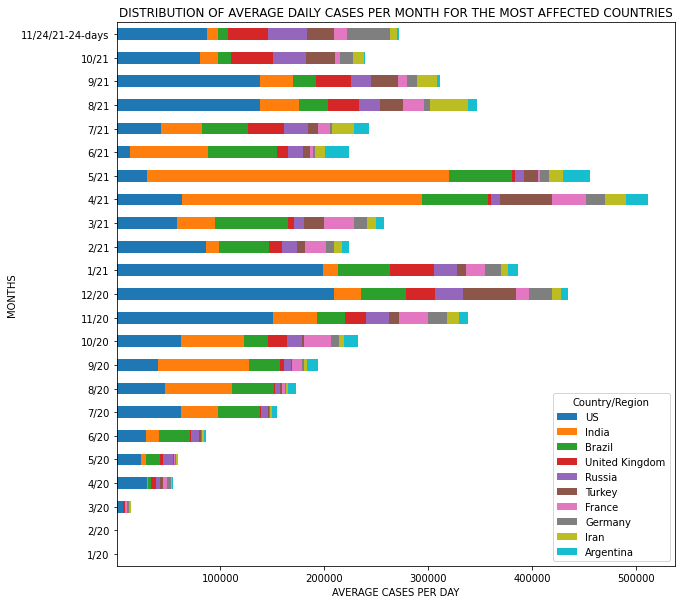

In [44]:
plot_func_bar(most_cases,"DISTRIBUTION OF AVERAGE DAILY CASES PER MONTH FOR THE MOST AFFECTED COUNTRIES")

%

#plotting the graph for the countries with the highest number of cases by calling plot_func function

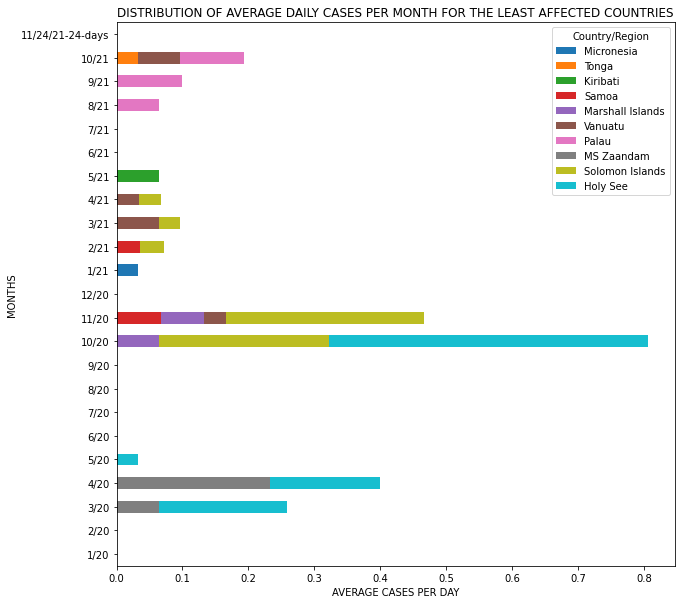

In [11]:
plot_func_bar(least_cases,"DISTRIBUTION OF AVERAGE DAILY CASES PER MONTH FOR THE LEAST AFFECTED COUNTRIES")

%

plotting the graph for the countries with the highest number of cases by calling plot_func function

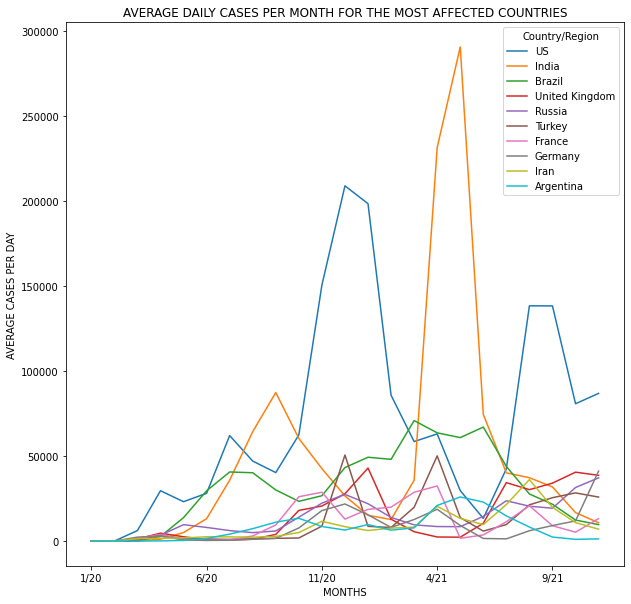

In [12]:
plot_func_line(most_cases,"AVERAGE DAILY CASES PER MONTH FOR THE MOST AFFECTED COUNTRIES")

%<br>
#plotting the graph for the countries with the least number of cases by calling plot_func function

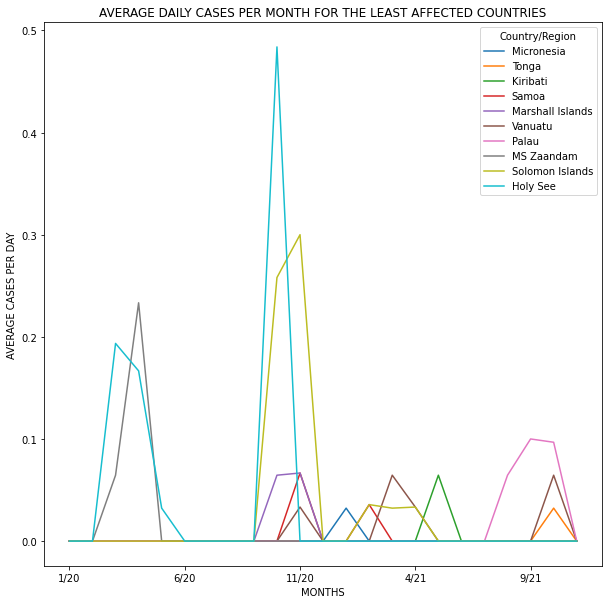

In [13]:
plot_func_line(least_cases,"AVERAGE DAILY CASES PER MONTH FOR THE LEAST AFFECTED COUNTRIES")

In[3]:

ropping unwanted columns and grouping by countries

In [14]:
df = data

.groupBy("Province/State").sum()

In[4]:

In [15]:
w = Window.partitionBy(lit(1)).orderBy(lit(1))

eparating the country column and dates column

In [16]:
country_region = df.select(df.columns[:4])
data_by_dates = df.select(df.columns[4:])

In[5]:

enaming date columns after groupby

In [17]:
headers_before_groupby =  data.select(data.columns[4:]).columns
headers_after_groupby = data_by_dates.columns

In [18]:
mapping = dict(zip(headers_after_groupby,headers_before_groupby))
renamed_frame_afterGroupby = data_by_dates.select([col(c).alias(mapping.get(c, c)) for c in data_by_dates.columns])

In[6]:

etting the last date in a month as the other days are redundant for finding the mean

In [19]:
lastdates = []
for i in range(len(headers_before_groupby)):
    try:
        if headers_before_groupby[i+1].split("/")[0] != headers_before_groupby[i].split("/")[0]:
            lastdates.append(headers_before_groupby[i])
    except:
        lastdates.append(headers_before_groupby[-1])
#concatenating the number of days in each month    
lstdat = []
for i in lastdates:
    if i == '1/31/20':
        lstdat.append(i+"-8"+"-days")
    else:
        lstdat.append(i+"-"+i.split("/")[1]+"-days")
        
Data_datesLast = renamed_frame_afterGroupby.select(lastdates)

In[7]:

enaming multiple columns

In [20]:
from pyspark.sql.functions import col

In [21]:
mapping = dict(zip(lastdates,lstdat))
Last_dates_data = Data_datesLast.select([col(c).alias(mapping.get(c, c)) for c in Data_datesLast.columns])

In[8]:

nitializing variables to assist in joining dataframes

In [22]:
ls = Last_dates_data.columns
fin = Last_dates_data.select(Last_dates_data.columns[0])
DF1 = fin.withColumn("row_id", row_number().over(w))

In[9]:

ooping though the Dataframe and calculating the mean, and then joining

In [23]:
for i in range(len(ls)):
    if i == 0:
        pass
    else:
        mean_fullframe = Last_dates_data.withColumn(ls[i],(F.col(ls[i])-F.col(ls[i-1])))
        mean_singleframe = mean_fullframe.select(mean_fullframe.columns[i])
        DF3 = mean_singleframe.withColumn("row_id", row_number().over(w))
        
        DF1 = DF1.join(DF3, ("row_id"))
# -F.col(ls[i-1])

In[10]:

dding an index to country/region to join

In [24]:
country = country_region.withColumn("row_id", row_number().over(w))

In[10]:

oining the country with the remaining dates dataframe

In [25]:
Final = DF1.join(country, on="row_id", how='full').drop("row_id")

In[11]:

earranging the columns and getting the final result

In [26]:
lst = Final.columns
Final = Final.select(lst[-4:] + lst[:-4])

#  Q2 Daily increase

In[12]:

earranging the data from cumulative to daily increase

In [27]:
date_columns=list(data_by_dates.columns)
for k in range(len(date_columns)-1):
    data_by_dates=data_by_dates.withColumn(date_columns[k],(data_by_dates[k+1]-data_by_dates[k]))

In[13]:

rop the last column which had kept cumulative values.

In [28]:
data_by_dates = data_by_dates.drop("11/18/21")

In[14]:

efine standard trendline function

In [29]:
def linearTrendlineCoefficient(*args):
    """
    Wrapper function of linear regression optimised for PySpark data
    Parameters
    ----------
    *args : tuple
        Unbounded list of data points.
    Returns
    -------
    float
        Linear coefficient of linear trendline fit of data points.
    """
    from sklearn.linear_model import LinearRegression
    import numpy as np
    X = []
    for value in args:
        X.append(value)
    X = np.array(X)
    y = np.arange(len(X))
    X = X.reshape((-1,1))
    y = y.reshape((-1,1))
    reg = LinearRegression().fit(y, X)
    coef_array = reg.coef_
    out = coef_array[0]
    return float(out)
#Convert to UDF
getLinearTrendlineCoef = udf(lambda *args: linearTrendlineCoefficient(*args), T.FloatType())
#Selecting columns for trendline
df_coef = data_by_dates
#Fitting trendline 
df_coef = df_coef.withColumn('Linear Coef', getLinearTrendlineCoef(*[F.col(i) for i in df_coef.columns]))

In[15]:

Add a row id to both dataframes

In [30]:
df_coef = df_coef.withColumn("row_id", row_number().over(w))
data_by_dates = data_by_dates.withColumn("row_id", row_number().over(w))

In[16]:

Join both datarframes 

In [31]:
country.join(df_coef.select('Linear Coef','row_id'), on='row_id', how='full_outer')
df_all = country.join(df_coef, on="row_id", how='full_outer').drop("row_id")
# Sort and filter the top 100 rows
df_all = df_all.sort(F.col("Linear Coef").desc())
data_top100 = df_all.limit(100)

# Continents<br>


In[17]:

In [32]:
import numpy as np
import pandas as pd
from matplotlib import path
def getContinent(lon, lat):
    '''
    
    Parameters
    ----------
    lon : Numbers
        Longitude.
    lat : Numbers
        Latitude.
    Returns
    -------
    String
        Continent.
    '''

    # Coordinates - America
    LonNAm = np.array([90,       90,  78.13,      57.5,  15,  15,  1.25,  1.25,  51,  60,    60])
    LatNAm = np.array([-168.75, -10,    -10,     -37.5, -30, -75, -82.5, -105,  -180, -180, -168.75])
    LatNA2 = np.array([51,    51,  60])
    LonNA2 = np.array([166.6, 180, 180])
    LatNA3 = np.array([22, 18, 19, 23])#hawaii
    LonNA3 = np.array([-160, -160, -153, -153])#hawaii
    LonSAm = np.array([1.25,  1.25,   15,  15, -60, -60])
    LatSAm = np.array([-105, -82.5,  -75, -30, -30, -105])

    # Coordinates - Europe
    LonEur = np.array([90,   90,  42.5, 42.5, 40.79, 41, 40.55, 40.40, 40.05, 39.17, 35.687499, 35.46, 33,   38,  35.42, 28.25, 15,  57.5,  78.13])
    LatEur = np.array([-10, 77.5, 48.8, 30,   28.81, 29, 27.31, 26.75, 26.36, 25.19, 13.911866, 27.91, 27.5, 10, -10,  -13,   -30, -37.5, -10])
    LatEu1 = np.array([14.150906, 14.090299, 14.811997, 14.826364])
    LonEu1 = np.array([36.304948, 35.741447, 35.710506, 36.195053])
    
    #Coordinates - Africa
    LonAfr = np.array([15,  28.25, 35.42, 35.687499, 38, 33,   31.74, 29.54, 27.78, 11.3, 12.5, -60, -60])
    LatAfr = np.array([-30, -13,   13.911866,-10, 10, 27.5, 34.58, 34.92, 34.46, 44.3, 52,    75, -30])
    LonAf1 = np.array([32.035586, 32.035586, 31.338941, 31.338941])
    LatAf1 = np.array ([-6.00000, - 8.338103, -8.338103, -6.00000])
    
    #Coordinates - Asia
    LonAsi = np.array([90,   42.5, 42.5, 40.79, 41, 40.55, 40.4,  40.05, 39.17, 35.46, 33,   31.74, 29.54, 27.78, 11.3, 12.5, -60, -60, -31.88, -11.88, -10.27, 33.13, 51,    60,  90])
    LatAsi = np.array([77.5, 48.8, 30,   28.81, 29, 27.31, 26.75, 26.36, 25.19, 27.91, 27.5, 34.58, 34.92, 34.46, 44.3, 52,   75,  110,  110,  110,    140,    140,   166.6, 180, 180])
    LatAs2 = np.array([90,    90,      60,      60,])
    LonAs2 = np.array([-180, -168.75, -168.75, -180,])
    
    #Coordinates - Antarctica
    LonAnt = np.array([-60, -60, -90, -90])
    LatAnt = np.array([-180, 180, 180, -180])
    
    def inContinent(xq, yq, xv, yv):
        xq = np.array(xq)
        yq = np.array(yq)
        xv = np.array(xv)
        yv = np.array(yv)
        shape = xq.shape
        xq = xq.reshape(-1)
        yq = yq.reshape(-1)
        xv = xv.reshape(-1)
        yv = yv.reshape(-1)
        q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
        p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
        return p.contains_points(q).reshape(shape)
    def inNA(lat, lon):
        if (lat==0 and lon==0) or (pd.isna(lat)==True or pd.isna(lon)==True):
            return True
        else:
            return False
    
    #Checking truth values
    inIntl = inNA(lat, lon)
    
    if inIntl==True:
        return 'Not applicable'
    else: 
        inNAm = inContinent(lon, lat, LonNAm, LatNAm)
        inNA2 = inContinent(lon, lat, LonNA2, LatNA2)
        inNA3 = inContinent(lon, lat, LonNA3, LatNA3)
        inSAm = inContinent(lon, lat, LonSAm, LatSAm)
    
    if inNAm==True or inNA2==True or inNA3==True or inSAm==True:
        return 'America'
    else: 
        inEur = inContinent(lon, lat, LonEur, LatEur)
        inEu1 = inContinent(lon, lat, LonEu1, LatEu1)
    
    if inEur==True or inEu1==True:
        return 'Europe'
    
    else:
        inAsi = inContinent(lon, lat, LonAsi, LatAsi)
        inAs2 = inContinent(lon, lat, LonAs2, LatAs2)
    
    if inAsi==True or inAs2==True:
        return 'Asia'
    else:
        inAfr = inContinent(lon, lat, LonAfr, LatAfr)
        inAf1 = inContinent(lon, lat, LonAf1, LatAf1)
    
    if inAfr==True or inAf1==True:
        return 'Africa'
    else:
        inAnt = inContinent(lon, lat, LonAnt, LatAnt)
    
    if inAnt==True:
        return 'Antarctica'
    else:
        return 'Oceania'

In [33]:
from pyspark.sql.functions import udf
continentLabeler = udf(lambda lon, lat: getContinent(lon, lat))
spark.udf.register("continentLabeler", continentLabeler)

<function __main__.<lambda>(lon, lat)>

In [42]:
data_continent = data_top100.withColumn('Continent', continentLabeler('Lat', 'Long'))

In[18]:

In [35]:
data_continent = data_continent.drop("Province/State","Country/Region","Lat","Long","Linear Coef")

In[19]:

Group and sum the values by continent

In [43]:
data_continent = data_continent.groupBy("Continent").sum()
data_continent.toPandas()

,Continent,sum(Lat),sum(Long),sum(1/22/20),sum(1/23/20),sum(1/24/20),sum(1/25/20),sum(1/26/20),sum(1/27/20),sum(1/28/20),...,sum(11/15/21),sum(11/16/21),sum(11/17/21),sum(11/19/21),sum(11/20/21),sum(11/21/21),sum(11/22/21),sum(11/23/21),sum(11/24/21),sum(Linear Coef)
0,Europe,1671.148069,514.910374,0,2,1,0,1,4,2,...,289275,342981,335381,276656,216830,330928,310189,392149,62266276,1056.130445
1,Africa,99.049673,214.678260,0,0,0,0,0,0,0,...,2522,2810,2496,2463,2696,2371,21025,3281,6791898,111.342593
2,America,204.407857,-1753.570167,0,1,0,4,0,1,1,...,105246,142974,138986,70146,48932,176367,116077,140165,95713147,1504.814765
3,Asia,929.415792,2421.032214,3,4,6,6,3,11,7,...,121426,127278,125409,120727,113148,112104,150278,123918,89767731,1571.248658


In[21]:

In [37]:
df_date_continent = data_continent.drop("Continent")

In[22]:

In [39]:
list_Europe = df_date_continent.collect()[0]
list_Africa = df_date_continent.collect()[1]
list_Oceania = df_date_continent.collect()[2]
list_America = df_date_continent.collect()[3]
list_Asia = df_date_continent.collect()[4]

IndexError: list index out of range

In[23]:

In [ ]:
data_Europe=[list_Europe[0]]
data_Africa=[list_Africa[0]]
data_Oceania=[list_Oceania[0]]
data_America=[list_America[0]]
data_Asia=[list_Asia[0]]

In[24]:

reates a list of sublists. Each one of the sublist contain 7 days

In [ ]:
list_eu = [list_Europe[i:i + 7] for i in range(0, len(list_Europe), 7)]
list_af = [list_Africa[i:i + 7] for i in range(0, len(list_Africa), 7)]
list_oc = [list_Oceania[i:i + 7] for i in range(0, len(list_Oceania), 7)]
list_am = [list_America[i:i + 7] for i in range(0, len(list_America), 7)]
list_as = [list_Asia[i:i + 7] for i in range(0, len(list_Asia), 7)]

In[25]:

In [ ]:
mean_week_eu = [np.mean(i) for i in list_eu]
std_week_eu = [np.std(i) for i in list_eu]
max_week_eu = [max(i) for i in list_eu]
min_week_eu = [min(i) for i in list_eu]

In [ ]:
mean_week_af = [np.mean(i) for i in list_af]
std_week_af = [np.std(i) for i in list_af]
max_week_af = [max(i) for i in list_af]
min_week_af = [min(i) for i in list_af]

In [ ]:
mean_week_oc = [np.mean(i) for i in list_oc]
std_week_oc= [np.std(i) for i in list_oc]
max_week_oc = [max(i) for i in list_oc]
min_week_oc = [min(i) for i in list_oc]
    
mean_week_am = [np.mean(i) for i in list_am]
std_week_am = [np.std(i) for i in list_am]
max_week_am = [max(i) for i in list_am]
min_week_am = [min(i) for i in list_am]
    
mean_week_as = [np.mean(i) for i in list_as]
std_week_as = [np.std(i) for i in list_as]
max_week_as = [max(i) for i in list_as]
min_week_as = [min(i) for i in list_as]
    

In[26]:

In [ ]:
df_eu_mean = pd.DataFrame(mean_week_eu ,columns = ["Mean"])
df_eu_std = pd.DataFrame(std_week_eu ,columns = ["Std"])
df_eu_max = pd.DataFrame(max_week_eu ,columns = ["Max"])
df_eu_min = pd.DataFrame(min_week_eu ,columns = ["Min"])

In [ ]:
result_eu = pd.concat([df_eu_mean, df_eu_std, df_eu_max, df_eu_min], axis = 1)
result_eu.index = np.arange(1, len(result_eu) + 1)
result_eu.index.name = 'Europe'

In[27]:

In [ ]:
df_af_mean = pd.DataFrame(mean_week_af ,columns = ["Mean"])
df_af_std = pd.DataFrame(std_week_af ,columns = ["Std"])
df_af_max = pd.DataFrame(max_week_af ,columns = ["Max"])
df_af_min = pd.DataFrame(min_week_af ,columns = ["Min"])

In [ ]:
result_af = pd.concat([df_af_mean, df_af_std, df_af_max, df_af_min], axis = 1)
result_af.index = np.arange(1, len(result_af) + 1)
result_af.index.name = 'Afrique'

In[28]:

In [ ]:
df_oc_mean = pd.DataFrame(mean_week_oc ,columns = ["Mean"])
df_oc_std = pd.DataFrame(std_week_oc ,columns = ["Std"])
df_oc_max = pd.DataFrame(max_week_oc ,columns = ["Max"])
df_oc_min = pd.DataFrame(min_week_oc ,columns = ["Min"])

In [ ]:
result_oc = pd.concat([df_oc_mean, df_oc_std, df_oc_max, df_oc_min], axis = 1)
result_oc.index = np.arange(1, len(result_oc) + 1)
result_oc.index.name = 'Oceania'

In[29]:

In [ ]:
df_am_mean = pd.DataFrame(mean_week_am ,columns = ["Mean"])
df_am_std = pd.DataFrame(std_week_am ,columns = ["Std"])
df_am_max = pd.DataFrame(max_week_am ,columns = ["Max"])
df_am_min = pd.DataFrame(min_week_am ,columns = ["Min"])

In [ ]:
result_am = pd.concat([df_am_mean, df_am_std, df_am_max, df_am_min], axis = 1)
result_am.index = np.arange(1, len(result_am) + 1)
result_am.index.name = 'America'

In[30]:

In [ ]:
df_as_mean = pd.DataFrame(mean_week_as ,columns = ["Mean"])
df_as_std = pd.DataFrame(std_week_as ,columns = ["Std"])
df_as_max = pd.DataFrame(max_week_as ,columns = ["Max"])
df_as_min = pd.DataFrame(min_week_as ,columns = ["Min"])

In [ ]:
result_as = pd.concat([df_as_mean, df_as_std, df_as_max, df_as_min], axis = 1)
result_as.index = np.arange(1, len(result_as) + 1)
result_as.index.name = 'Asia'

###  2nd Query's output

In[33]:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
def plot_func(df_eu,df_af,df_oc,df_am,df_as,xlabel,ylabel,title):
    '''
    
    Parameters
    ----------
    df_eu : List
        European values.
    df_af : List
        African values.
    df_oc : List
        European values.
    df_am : List
        America values.
    df_as : List
        Asia values.
    xlabel : String
        x axis label.
    ylabel : String
        y axis label.
    title : String
        Plot title .
    Returns
    -------
    Plot
        Plot data depending on different continents.
    '''
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    Europe = mpatches.Patch(color='r', label='Europe')
    Africa = mpatches.Patch(color='b', label='Africa')
    Oceania = mpatches.Patch(color='b', label='Oceania')
    America = mpatches.Patch(color='g', label='America')
    Asia = mpatches.Patch(color='black', label='Asia')
    plt.legend(handles=[Europe,Africa, Oceania ,America, Asia])
    ax.plot(range(len(df_eu)), df_eu, color='r')
    ax.plot(range(len(df_af)), df_af, color='b')
    ax.plot(range(len(df_oc)), df_af, color='orange')
    ax.plot(range(len(df_am)), df_am, color='g')
    ax.plot(range(len(df_as)), df_as, color='violet')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return plt.show()

In[34]:

onfirmed Cases per Day per Continent

In [ ]:
Yeu = list_Europe
Yaf = list_Africa
Yoc = list_Oceania
Yam = list_America
Yas = list_Asia

In [ ]:
x_lab = "Number of days"
y_lab = "Confirmed Cases"
title = "Confirmed Cases per Day per Continent"
plot_func(Yeu,Yaf,Yoc,Yam,Yas,x_lab,y_lab,title)

In[35]:

Mean of the Daily Cases per weeks per Continent

In [ ]:
Yeu = df_eu_mean
Yaf = df_af_mean
Yoc = df_oc_mean
Yam = df_am_mean
Yas = df_as_mean

In [ ]:
x_lab = 'Number of weeks'
y_lab = 'Mean of the Daily Cases'
title = 'Mean of the Daily Cases per weeks per Continent'
plot_func(Yeu,Yaf,Yoc,Yam,Yas,x_lab,y_lab,title)

In[36]:

tandard Deviation of the Daily Cases per weeks per Continent

In [ ]:
Yeu = df_eu_std
Yaf = df_af_std
Yoc = df_oc_std
Yam = df_am_std
Yas = df_as_std

In [ ]:
x_lab = 'Number of weeks'
y_lab = 'Standard Deviation of the Daily Cases'
title = 'Standard Deviation of the Daily Cases per weeks per Continent'

In [ ]:
plot_func(Yeu,Yaf,Yoc,Yam,Yas,x_lab,y_lab,title)

In[37]:

inimum of Daily Cases per weeks per Continent

In [ ]:
Yeu = abs(df_eu_min)
Yaf = df_af_min
Yoc = df_oc_min
Yam = df_am_min
Yas = df_as_min

In [ ]:
x_lab = 'Number of weeks'
y_lab = 'Minimum of Daily Cases'
title = 'Minimum of Daily Cases per weeks per Continent'

In [ ]:
plot_func(Yeu,Yaf,Yoc,Yam,Yas,x_lab,y_lab,title)

In[38]:

In [ ]:
Yeu = df_eu_min
Yaf = df_af_max
Yoc = df_oc_max
Yam = df_am_max
Yas = df_as_max

In [ ]:
x_lab = 'Number of weeks'
y_lab = 'Maximum of Daily Cases'
title = 'Maximum of Daily Cases per weeks per Continent'

In [ ]:
plot_func(Yeu,Yaf,Yoc,Yam,Yas,x_lab,y_lab,title)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  7 17:23:31 2021

% Importing libraries

In [ ]:
import numpy as np
import findspark
findspark.init()
import pyspark
findspark.find()
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Comment out if not using cluster<br>
conf = pyspark.SparkConf()<br>
conf.setMaster("spark://login1-sinta-hbc:7077").setAppName("jupyter") #comment out if not using cluster

spark = pyspark.sql.SparkSession.builder \<br>
    .master("spark://login1-sinta-hbc:7077") \<br>
    .appName("jupyter") \<br>
    .getOrCreate()

 Local configuration

In [ ]:
conf = pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
from pyspark.sql import functions as F 
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lit
from pyspark.sql.functions import udf
from pyspark.sql import types as T
import pandas as pd

% Defining all functions

In [ ]:
def getMonthlyIncreases(data):
    ### Wrapper function to run PySpark calculations of monthly increases
    # Dropping unwanted columns and grouping by countries
    df = data
    w = Window.partitionBy(lit(1)).orderBy(lit(1))
    country_region = df.select(df.columns[:4])
    data_by_dates = df.select(df.columns[4:])
    
    #Renaming date columns after groupby
    headers_before_groupby =  data.select(data.columns[4:]).columns
    headers_after_groupby = data_by_dates.columns
    mapping = dict(zip(headers_after_groupby,headers_before_groupby))
    renamed_frame_afterGroupby = data_by_dates.select([F.col(c).alias(mapping.get(c, c)) for c in data_by_dates.columns])
    
    #Getting the last date in a month as the other days are redundant for finding the mean
    lastdates = []
    for i in range(len(headers_before_groupby)):
        try:
            if headers_before_groupby[i+1].split("/")[0] != headers_before_groupby[i].split("/")[0]:
                lastdates.append(headers_before_groupby[i])
        except:
            lastdates.append(headers_before_groupby[-1])
    #Concatenating the number of days in each month    
    lstdat = []
    for i in lastdates:
        if i == '1/31/20':
            lstdat.append(i+"-8"+"-days")
        else:
            lstdat.append(i+"-"+i.split("/")[1]+"-days")
            
    Data_datesLast = renamed_frame_afterGroupby.select(lastdates)
    #Renaming multiple columns
    mapping = dict(zip(lastdates,lstdat))
    Last_dates_data = Data_datesLast.select([F.col(c).alias(mapping.get(c, c)) for c in Data_datesLast.columns])
    
    #Initializing variables to assist in joining dataframes
    ls = Last_dates_data.columns
    fin = Last_dates_data.select(Last_dates_data.columns[0])
    DF1 = fin.withColumn("row_id", row_number().over(w))
    
    #Looping though the Dataframe and calculating the mean, and then joining
    for i in range(len(ls)):
        if i == 0:
            pass
        else:
            increases_fullframe = Last_dates_data.withColumn(ls[i],(F.col(ls[i])-F.col(ls[i-1])))
            increases_singleframe = increases_fullframe.select(increases_fullframe.columns[i])
            DF3 = increases_singleframe.withColumn("row_id", row_number().over(w))
            DF1 = DF1.join(DF3, ("row_id"))
    
    #Adding an index to country/region to join
    country = country_region.withColumn("row_id", row_number().over(w))
    
    #Joining the country with the remaining dates dataframe
    monthly_increases = DF1.join(country, on="row_id", how='full').drop("row_id")
    
    #Rearranging the columns and getting the final result
    lst = monthly_increases.columns
    monthly_increases = monthly_increases.select(lst[-4:] + lst[:-4])
    monthly_increases = monthly_increases.toPandas()
    return monthly_increases

In [ ]:
def getMonthlyAverage(data):
    ### Wrapper function to run PySpark calculations of monthly average
    #Dropping unwanted columns and grouping by countries
    df = data
    w = Window.partitionBy(lit(1)).orderBy(lit(1))
    country_region = df.select(df.columns[:4])
    data_by_dates = df.select(df.columns[4:])
    
    #Renaming date columns after groupby
    headers_before_groupby =  data.select(data.columns[4:]).columns
    headers_after_groupby = data_by_dates.columns
    mapping = dict(zip(headers_after_groupby,headers_before_groupby))
    renamed_frame_afterGroupby = data_by_dates.select([F.col(c).alias(mapping.get(c, c)) for c in data_by_dates.columns])
    
    #Getting the last date in a month as the other days are redundant for finding the mean
    lastdates = []
    for i in range(len(headers_before_groupby)):
        try:
            if headers_before_groupby[i+1].split("/")[0] != headers_before_groupby[i].split("/")[0]:
                lastdates.append(headers_before_groupby[i])
        except:
            lastdates.append(headers_before_groupby[-1])
    #Concatenating the number of days in each month    
    lstdat = []
    for i in lastdates:
        if i == '1/31/20':
            lstdat.append(i+"-8"+"-days")
        else:
            lstdat.append(i+"-"+i.split("/")[1]+"-days") 
    Data_datesLast = renamed_frame_afterGroupby.select(lastdates)
    #Renaming multiple columns
    mapping = dict(zip(lastdates,lstdat))
    Last_dates_data = Data_datesLast.select([col(c).alias(mapping.get(c, c)) for c in Data_datesLast.columns])
    
    #Initializing variables to assist in joining dataframes
    ls = Last_dates_data.columns
    fin = Last_dates_data.select(Last_dates_data.columns[0])
    DF1 = fin.withColumn("row_id", row_number().over(w))
    
    #Looping though the Dataframe and calculating the mean, and then joining
    for i in range(len(ls)):
        if i == 0:
            pass
        else:
            increases_fullframe = Last_dates_data.withColumn(ls[i],(F.col(ls[i])-F.col(ls[i-1]))/int(ls[i].split("-")[1]))
            increases_singleframe = increases_fullframe.select(increases_fullframe.columns[i])
            DF3 = increases_singleframe.withColumn("row_id", row_number().over(w))
            DF1 = DF1.join(DF3, ("row_id"))
    
    #Adding an index to country/region to join
    country = country_region.withColumn("row_id", row_number().over(w))
    
    #Joining the country with the remaining dates dataframe
    mean_values = DF1.join(country, on="row_id", how='full').drop("row_id")
    
    #Rearranging the columns and getting the final result
    lst = mean_values.columns
    mean_values = mean_values.select(lst[-4:] + lst[:-4])
    mean_values = mean_values.toPandas()
    return mean_values

In [ ]:
def kMeansFit(*args):
    """
    Function to cluster data points
    Parameters
    ----------
    *args : tuple
        Unbounded list of data points.
    Returns
    -------
    out : string
        String of cluster IDs, in place of list to support conversion into PySpark UDF.
    """
    import numpy as np
    import pandas as pd
    k=4
    np.random.seed(42)
    def __normaliseValues(df):
        out = []
        for label, content in df.items():
            feature = df[label]
            numerator = feature - np.min(feature)
            denominator = np.max(feature) - np.min(feature)
            output = numerator/denominator
            out.append(output)
        out = np.array(out).T
        out = pd.DataFrame.from_records(out)
        out.columns = df.columns
        return out    
    def __updateCentroid(y, centroids, centroids_pointwise):
        centroid_update = []
        for i in range(len(centroids)):
            centroid_y = 0
            count = 1
            for n in range(len(centroids_pointwise)):
                if centroids_pointwise[n] == centroids[i]:
                    centroid_y += y[n]
                    count +=1
            centroid_final = centroid_y/count
            centroid_update.append(centroid_final)
        return np.array(centroid_update)
            
    def __getPointwiseCentroid(y, centroids):
        centroids_pointwise = []
        for n in range(len(y)):
            distance_list = []
            y_i = y[n]
            for i in range(len(centroids)):
                distance = np.sqrt((y_i-centroids[i])**2)
                distance_list.append(distance)
            distance_list = np.array(distance_list)
            assigned_centroid = centroids[np.argmin(distance_list)]
            centroids_pointwise.append(assigned_centroid)
        return np.array(centroids_pointwise)
    df = []
    for value in args:
        df.append(value)
    df = pd.DataFrame(df)
    df = __normaliseValues(df)
    y = df.mean(axis=1)
    centroids = y.sample(k)
    centroids.reset_index(drop=True, inplace=True)
    count = 1
    tol = None
    while True:
        centroids_pointwise = __getPointwiseCentroid(y, centroids)
        centroids = __updateCentroid(y, centroids, centroids_pointwise)
        avg = np.mean(centroids)
        if tol is not None and avg == tol:
            break
        tol = avg
        count+=1 
    out = __getPointwiseCentroid(y, centroids)
    _, out = np.unique(out, return_inverse=True)
    out = list(out)
    out = str(out)
    return out

In [ ]:
def convertClusteringOutput(clusters):
    """
    Converts string output from kMeansFit into array.
    Parameters
    ----------
    clusters : string
        String form of cluster identification.
    Returns
    -------
    out : Pandas dataframe
        Dataframe form of cluster identification.
    """
    cluster_array = np.array(clusters)
    cluster_array = list(cluster_array)
    out = []
    for i in cluster_array:
        strsize = len(i[0])
        x = i[0][1:(strsize-1)]
        x = list(map(int, x.split(',')))
        out.append(x)
    out = pd.DataFrame(out)
    out = out.T
    out.set_axis(['01/20', '02/20', '03/20', '04/20', '05/20', '06/20', '07/20', '08/20', '09/20','10/20', '11/20', '12/20', '01/21', '02/21', '03/21', '04/21', '05/21', '06/21','07/21', '08/21', '09/21', '10/21', '11/21'], axis=1, inplace=True)
    return out
#%%
def normaliseValuesStd(df):
    """
    Normalises values between 0 and 1
    Parameters
    ----------
    df : pandas Dataframe
        Data points to be normalised.
    Returns
    -------
    out : pandas Dataframe
        Normalised data points.
    """
    out = []
    for label, content in df.items():
        feature = df[label]
        numerator = feature - np.min(feature)
        denominator = np.max(feature) - np.min(feature)
        output = numerator/denominator
        out.append(output)
    out = np.array(out).T
    out = pd.DataFrame.from_records(out)
    out.columns = df.columns
    return out 

% Obtainining monthly increases and monthly averages and  cleaning

In [ ]:
monthly_increases = getMonthlyIncreases(data)
mean_values = getMonthlyAverage(data)
monthly_increases = spark.createDataFrame(monthly_increases)
mean_values = spark.createDataFrame(mean_values)
df_vals = data.drop('Province/State', 'Country/Region', 'Lat', 'Long')
df_headers = data.select('Province/State', 'Country/Region', 'Lat', 'Long')

% Applying linear trendline coefficient calculation and sorting<br>
onvert to UDF

In [ ]:
getLinearTrendlineCoef = udf(lambda *args: linearTrendlineCoefficient(*args), T.FloatType())
#Selecting columns for trendline
w = Window.partitionBy(lit(1)).orderBy(lit(1))
df_coef = monthly_increases.select(monthly_increases.columns[4:])
#Fitting trendline 
df_coef = df_coef.withColumn('linear_coef', getLinearTrendlineCoef(*[F.col(i) for i in df_coef.columns]))
#Sorting output
df_coef = df_coef.withColumn("row_id", row_number().over(w))
df_vals = df_vals.withColumn("row_id", row_number().over(w))
df_headers = df_headers.withColumn("row_id", row_number().over(w))
mean_values = mean_values.withColumn("row_id", row_number().over(w))
df_headers = df_headers.join(df_coef.select('linear_coef','row_id'), on='row_id', how='full_outer')
df_mean = df_headers.join(mean_values.drop('Province/State', 'Country/Region', 'Lat', 'Long'), on="row_id", how='full_outer').drop("row_id")
df_mean = df_mean.sort(F.col("linear_coef").desc())

% Taking only top 50 values

In [ ]:
top50 = df_mean.limit(50)

% Transposing output out of PySpark to ease computation of Kmeans

In [ ]:
top50_p = top50.toPandas()
top50_p = top50_p.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'linear_coef'])
top50_p = top50_p.T
top50_T = spark.createDataFrame(top50_p)

% K-means clustering

In [ ]:
getKmeansCluster = udf(lambda *args: kMeansFit(*args), T.StringType())
#Fitting cluster 
top50_T = top50_T.withColumn('cluster_id', getKmeansCluster(*[F.col(i) for i in top50_T.columns]))
# Sorting cluster output
clusters = top50_T.select('cluster_id').toPandas()

% Converting output and joining with data

In [ ]:
df_clusterID = convertClusteringOutput(clusters)
df_clusterID = spark.createDataFrame(df_clusterID)
df_clusterID = df_clusterID.withColumn("row_id", row_number().over(w))
top50_headers = top50.select('Province/State', 'Country/Region', 'Lat', 'Long', 'linear_coef').withColumn("row_id", row_number().over(w))
df_clusterID = top50_headers.join(df_clusterID, on='row_id', how='full').drop('row_id')
pdClusterID = df_clusterID.toPandas()

% Writing  output to CSV

In [ ]:
months = ['01/20', '02/20', '03/20', '04/20', '05/20', '06/20', '07/20', '08/20', '09/20','10/20', '11/20', '12/20', '01/21', '02/21', '03/21', '04/21', '05/21', '06/21','07/21', '08/21', '09/21', '10/21', '11/21']
pdClusterID.to_csv('cluster_out.csv')

% Sorting output for plotting

In [ ]:
monthlyIncTop50 = df_headers.join(df_coef.drop('linear_coef'), on="row_id", how='full_outer').drop("row_id")
monthlyIncTop50 = monthlyIncTop50.sort(F.col("linear_coef").desc()).limit(50)
pdMonthlyInc = monthlyIncTop50.toPandas()
pdMonthlyMean= top50.toPandas()

% Visualisation 

In [ ]:
vis_month_selection = -1
cluster_colour = pdClusterID.iloc[:, vis_month_selection]
vis_data = pd.concat((pdMonthlyMean['linear_coef'], pdMonthlyMean.iloc[:, vis_month_selection]), axis=1)
# print(pdClusterID.iloc[:, vis_month_selection].name)
vis_data = np.array(vis_data)
from scipy.spatial import ConvexHull

lot 1: Monthly scatterplot

In [ ]:
def drawclusters(ax,  X, labels, colours, ncluster=4):
    """
    Draws clusters and fits a convex hull to ease visualisation. A convex hull
    is the smallest convex boundary of the cluster cloud.
    Parameters
    ----------
    ax : plt object
        matplotlib object instance.
    X : numpy array
        scatter data to be plotted.
    labels : numpy array
        data labels for each point.
    colours : list
        list of selected clusters.
    ncluster : int, optional
        Number of convex hull instances to generate. The default is 4.
    Returns
    -------
    None.
    """
    for i in range(ncluster):
        points = X[labels == i]
        ax.scatter(points[:, 0], points[:, 1], s=30, c=colours[i], label=f'Cluster {i}')
        ax.legend()
        hull = ConvexHull(points)
        vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
        ax.plot(points[vert, 0], points[vert, 1], '--', c=colours[i])
        ax.fill(points[vert, 0], points[vert, 1], c=colours[i], alpha=0.2)
        ax.set_xlabel('Overall daily linear coefficient')
        ax.set_ylabel('Mean of daily cases in a month')
        ax.set_title('Clustering of daily rates of month' )
        
fig, ax = plt.subplots(1, figsize=(7, 5))
colours = ['red', 'green', 'blue', 'orange']
drawclusters(ax, vis_data, cluster_colour, colours, ncluster=4)

lot 2: Seaborn heatmap plotting

In [ ]:
import seaborn as sns
heatmap_out = pdClusterID.drop(columns=['Country/Region', 'Province/State', 'Lat', 'Long', 'linear_coef'])
plt.figure(figsize=(16, 10))

In [ ]:
cmap = sns.color_palette("coolwarm", 4)
g = sns.heatmap(heatmap_out, cmap=cmap, linewidth=0.05, linecolor='lightgrey',  cbar_kws={"ticks":[0, 1, 2, 3]}, square=True)
g.set_yticklabels(pdClusterID['Country/Region'])
g.set_xticklabels(months, rotation = 80)

In [ ]:
plt.xlabel('')
plt.ylabel('')
plt.savefig('globalclust.pdf')
#%%
end_time = time.time()
print(end_time-strt_time)